# Прогнозирование заказов такси
___________


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Цель-исследования:" data-toc-modified-id="Цель-исследования:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Цель исследования:</a></span></li><li><span><a href="#Задачи-исследования:" data-toc-modified-id="Задачи-исследования:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Задачи исследования:</a></span></li><li><span><a href="#Исходные-данные:" data-toc-modified-id="Исходные-данные:-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Исходные данные:</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

### Цель исследования:

Построить модель машинного обучения для прогнозирования количества заказов такси на следующий час, при этом значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Задачи исследования:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


### Исходные данные:

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Для начала импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np

import copy

import seaborn as sns
import matplotlib.pyplot as plt 

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore') 

pd.options.mode.chained_assignment = None

Выведем первые строки датасета и общую информацию, предварительно поменяв тип данных столца `datetime` на тип *datetime64* и установив эти значения в качестве индексов.


In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

display(df.head())
print(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


В таблице представлены данные о количестве заказов в определенные промежутки времени.
Всего представлено 26496 значений от 1 марта 2018 года до 31 августа 2018 года. 
Количество заказов фиксировалось каждые 10 минут.


Проверим, данные на монотонность:

In [3]:
print(df.index.is_monotonic)

True


Получили, что данные монотонно увеличиваются, разрывы отсутствуют.

Исходные данные представлены с точностью до секунд. Произведем ресемплинг с детализацией даты до часа, в качестве агрегированного значения ряда примем суммарное количество заказов в разрезе выбранного интервала и посмотрим на вид распределения.

<AxesSubplot:xlabel='datetime'>

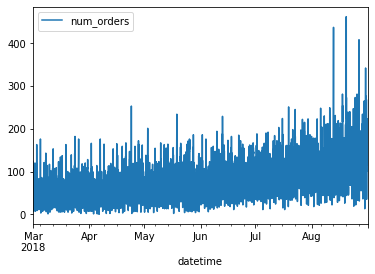

In [4]:
df = df.resample('1H').sum()
df.plot()

Как видно, данные достаточно плотно распределены, поэтому в дальнейшем необходимо будет разбить данные на чуть большие интервалы. Имеется небольшое количество выбросов.

### Вывод

В процессе подготовки данных было произведено следующее:

* Был изменен тип данных столца `datetime` на тип *datetime64* и установлены данные значения в качестве индексов. 

* Была произведена проверка данных на монотонность - получено, что разрывов не имеется и информация о количестве заказов предоставлена в промежутке времени от 2018-03-01 00:00:00 до 2018-08-31 23:50:00 с  интревалами в 10 мин.

* Было применено ресемплирование с детализацией даты до часов.

## Анализ

Осуществим снова ресемплинг с детализацией данных до 1 дня и оценим вид распределения.

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


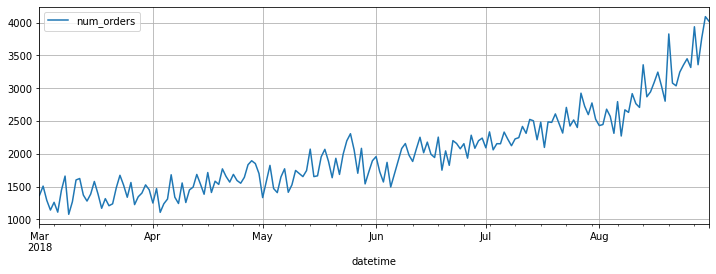

In [5]:
new_df = copy.copy(df)
new_df = new_df.resample('1D').sum()
new_df.plot(figsize=(12,4), grid=True)

new_df.head()

Визуально распределение воспринимается лучше, но необходимо снизить имеющиеся колебания, для этого применим скользящее среднее с размером окна, равным 7.  Так же добавим скользящее стандартное отклонение. 

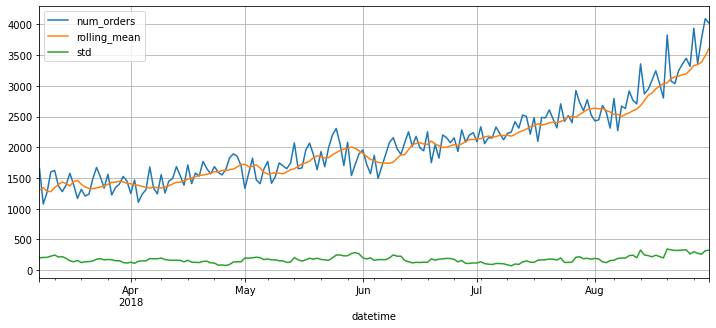

In [6]:
new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(7).mean()
new_df['std'] = new_df['num_orders'].rolling(7).std()
new_df = new_df.dropna()

new_df[['num_orders', 'rolling_mean', 'std']].plot(figsize=(12,5))
plt.grid()

По графику видно, что среднее значение со временем увеличивается, то есть временной ряд является нестационарным.

Далее разложим временной ряд на тренд, сезонную компоненту и шум.

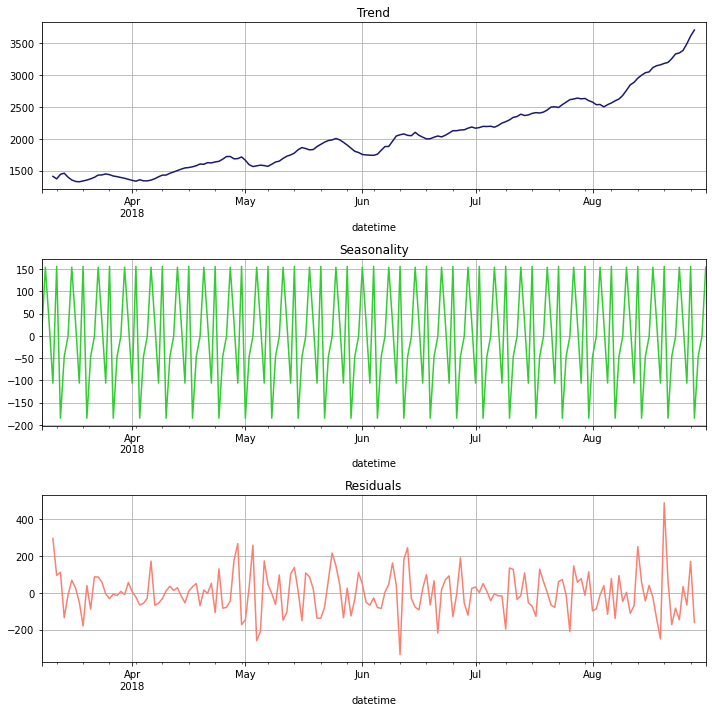

In [7]:
decomposed = seasonal_decompose(new_df['num_orders']) 

plt.figure(figsize=(10, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), grid=True, color='#191970')
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), grid=True, color='#32CD32') 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), grid=True, color='#FA8072') 
plt.title('Residuals')
plt.tight_layout()

Видим, что тренд имеет восходящий характер - увеличение количества заказов такси от месяца к месяцу. Период сезонности соответствует примерно неделе.

Рассмотрим график сезонности в разрезе недели и одних суток.

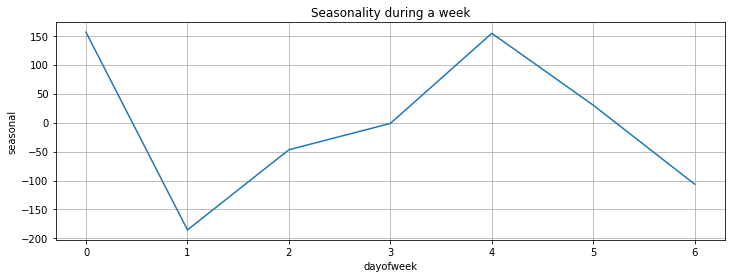

In [8]:
plt.figure(figsize=(12, 4))
new_df['dayofweek'] = new_df.index.dayofweek
week_seasonal = decomposed.seasonal['2018-03-12':'2018-03-18']
sns.lineplot(new_df['dayofweek'], week_seasonal)
plt.title('Seasonality during a week')
plt.grid()
plt.show()

Получаем, что наибольшее кол-во заказов соответствует таким дням недели как понедельник (0) и пятница (4), а минимальное - вторнику (1) и воскресенью (6).

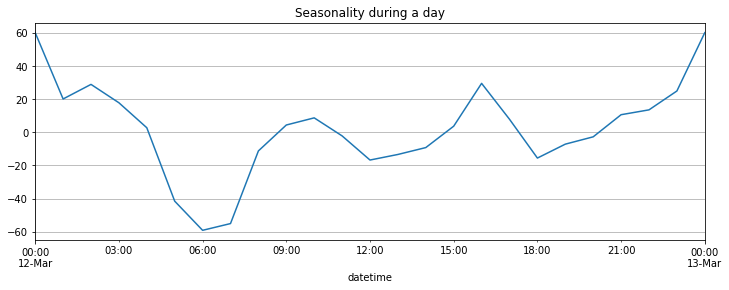

In [9]:
plt.figure(figsize=(12, 4))
seasonal_decompose(df['num_orders']).seasonal['2018-03-12 00:00:00':'2018-03-13 00:00:00'].plot()
plt.title('Seasonality during a day')
plt.grid()
plt.show()

В разрезе 1 суток пик заказов приходится на полночь, что можно объяснить тем, что эти заказы такси осуществлялись в аэропортах, из которых бывает достаточно сложно добраться до города в связи с отсутствием общественного транспорта в ночное время. Именно поэтому наименьшее количество заказов соотвествует 6 часам утра - начинают курсировать автобусы и маршрутки до города и потребность в такси у части клиентов отпадает.

Если выделять промежутки времени, когда заказов было больше всего, получаем время от полуночи до 4 часов утра, от 9:00 до 10:00, от 15:00 до 17:00 и от 20:00 и до полуночи.


### Вывод

По итогам анализа имеющихся данных было определено следующее:

* Среднее значение количества заказов такси со временем увеличивается, то есть представленный временной ряд является нестационарным. Наблюдается тренд на увеличение количества заказов такси от месяца к месяцу. Период сезонности соответствует примерно неделе.

* В разрезе одной недели наибольшее количество заказов соответствует таким дням недели как понедельник и пятница, а минимальное - вторнику и воскресенью.
 
* В разрезе одних суток пик заказов приходится на полночь, наименьшее количество заказов соотвествует 6 часам утра. Если выделять промежутки времени, когда заказов было больше всего, получаем время от полуночи до 4 часов утра, от 9:00 до 10:00, от 15:00 до 17:00 и от 20:00 и до полуночи.

## Обучение

Создадим дополнительные признаки для горизонта прогнозирования в один шаг и разделим данные на обучающую и тестовую выборки. 

In [10]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
make_features(df, 1, 24)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Создадим датафрейм и добавим функцию для сохранения результатов работы моделей в отдельной таблице.

In [12]:
results = pd.DataFrame(columns=['RMSE обучающей выборки',
                                'RMSE тестовой выборки'])

def metrics(rmse_train, rmse_test, model_name, df):
    df.loc[model_name,'RMSE обучающей выборки'] = rmse_train
    df.loc[model_name,'RMSE тестовой выборки'] = rmse_test
    return df

Напишем функцию по обучению моделей и расчету метрики RMSE для обучающей и тестовой выборки.

In [13]:
def train_model(model, model_name):
    model = model
    model.fit(features_train, target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    rmse_train = np.sqrt(mean_squared_error(target_train, train_pred))
    rmse_test = np.sqrt(mean_squared_error(target_test, test_pred))
    
    plt.figure(figsize=(12, 5))
    plt.plot(test_pred, "r", label="Test prediction")
    plt.plot(target_test.values, label="Test target")
    plt.legend(loc="best")
    plt.title(model_name)
    plt.grid(True)

    return  rmse_train, rmse_test

Попробуем обучить модель на обычной линейной регресии и затем оценим результаты.

,RMSE обучающей выборки,RMSE тестовой выборки
Linear Regression,30.907085,51.194081


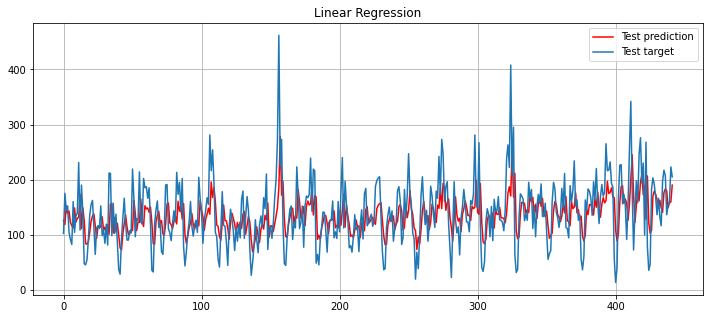

In [14]:
linreg_rmse_train, linreg_rmse_test = train_model(LinearRegression(), 'Linear Regression')

metrics(linreg_rmse_train, linreg_rmse_test, 'Linear Regression', results)

Получили небольшое расхождение, но недостаточное для нас (на тесте RMSE больше 48).

Посмотрим, как справится модель случайного леса.

,RMSE обучающей выборки,RMSE тестовой выборки
Linear Regression,30.907085,51.194081
Random Forest Regressor,8.686004,46.708868


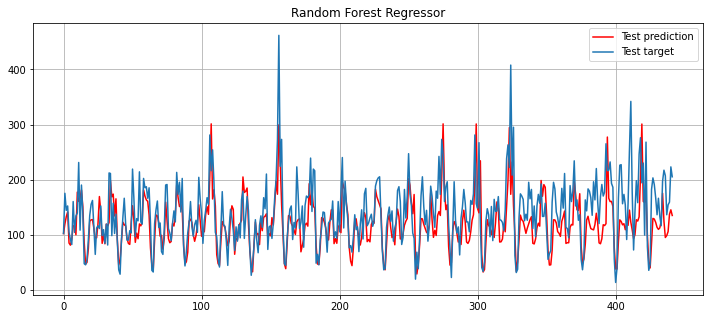

In [15]:
forest_rmse_train, forest_rmse_test = train_model(RandomForestRegressor(), 'Random Forest Regressor')

metrics(forest_rmse_train, forest_rmse_test, 'Random Forest Regressor', results)

Судя по результам, модель явно переобучилась - очень незначительная величична RMSE на обучающей выборке и больше, чем у линейной регресии на тестовой.

Попробуем провести оценку модели линейной регресии на кросс-валидации, по похожему принципу, что использовался в [данной](http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/) статье.

Суть состоит в том, что так как работа идет с временными рядами, мешать между собой данные нельзя, поэтому вместо того чтобы перемешивать датасет случайным образом и делить его на определенное количество групп, данные будем делить на *N* последовательных групп с учетом дат. Например, выделяем *10* последовательных фолдов, затем обучаем модель на *1* фолде, тестируем на втором, потом обучаем на *1* и *2* фолдах, тестируем на третьем и так далее. Затем, когда модель была протестирована на последнем *10* фолде (*N*), рассчитывается среднее значение точности *9 (N-1)* фолдов. 

In [23]:
def TimeSeriesCV(features_train, target_train, number_folds, model):
    #print('Size train set: {}'.format(features_train.shape))
   
    k = int(np.floor(float(features_train.shape[0]) / number_folds))
    #print('Size of each fold: {}'.format(k))

    errors_train = np.zeros(number_folds-1)
    errors_test = np.zeros(number_folds-1)
    
    for i in range(2, number_folds + 1):
        #print('')
        split = float(i-1)/i
        #print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        features = features_train[:(k*i)]
        target = target_train[:(k*i)]
        #print('Size of train + test: {}'.format(features.shape))

        index = int(np.floor(features.shape[0] * split))

        # для обучения модели     
        features_trainFolds = features[:index]        
        target_trainFolds = target[:index]

        # для тестирования модели
        features_testFold = features[(index + 1):]
        target_testFold = target[(index + 1):]

        model.fit(features_trainFolds, target_trainFolds)
        errors_train[i-2] = np.sqrt(mean_squared_error(model.predict(features_trainFolds), target_trainFolds))
        errors_test[i-2] = np.sqrt(mean_squared_error(model.predict(features_testFold), target_testFold))
        
        
        plt.figure(figsize=(12, 5))
        plt.plot(model.predict(features_testFold), "r", label="Test prediction")
        plt.plot(target_testFold.values, label="Test target")
        plt.legend(loc="best")
        plt.title(model)
        plt.grid(True)


    # функция возвращает RMSE для обучающей и тестовой выборок    
    return errors_train.mean(), errors_test.mean()

,RMSE обучающей выборки,RMSE тестовой выборки
Linear Regression,30.907085,51.194081
Random Forest Regressor,8.686004,46.708868
CV Linear Regression,26.992019,31.797042
CV Random Forest Regressor,7.459778,25.232633
CV LightGBM,13.340499,28.682495
CV CatBoostRegressor,12.101015,29.010079


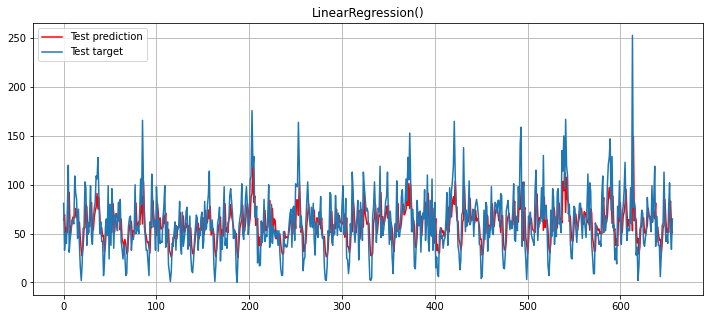

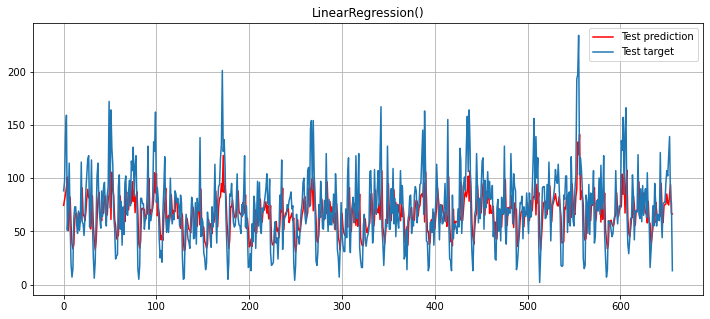

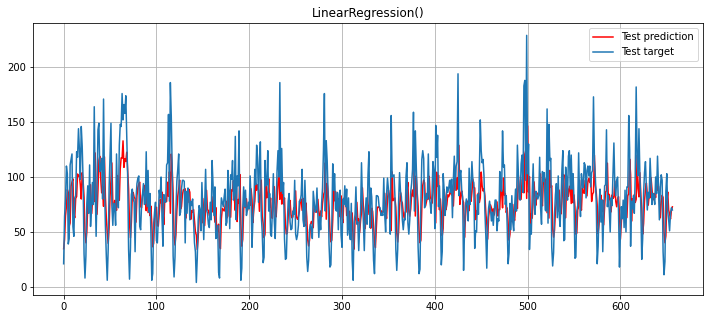

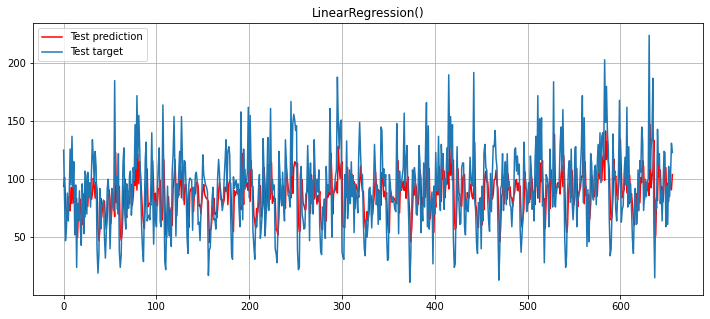

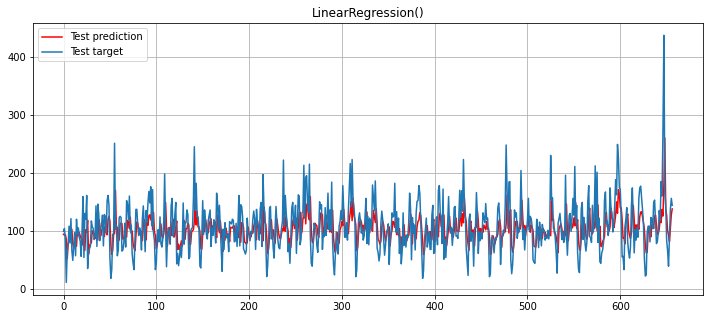

In [30]:
linreg_cv = LinearRegression()
linreg_cv_rmse_train, linreg_cv_rmse_test = TimeSeriesCV(features_train, target_train, 6, linreg_cv)
metrics(linreg_cv_rmse_train, linreg_cv_rmse_test, 'CV Linear Regression', results)



На кросс-валидации значение RMSE приблизилось к необходимому. Попробуем применить этот же метод для модели случайного леса.

,RMSE обучающей выборки,RMSE тестовой выборки
Linear Regression,30.907085,51.194081
Random Forest Regressor,8.686004,46.708868
CV Linear Regression,26.992019,31.797042
CV Random Forest Regressor,7.527633,25.657452
CV LightGBM,13.340499,28.682495
CV CatBoostRegressor,12.101015,29.010079


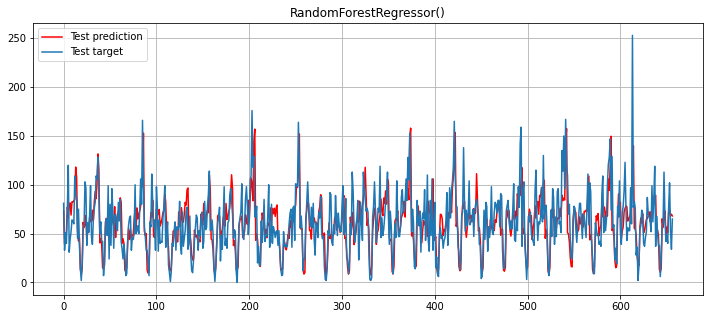

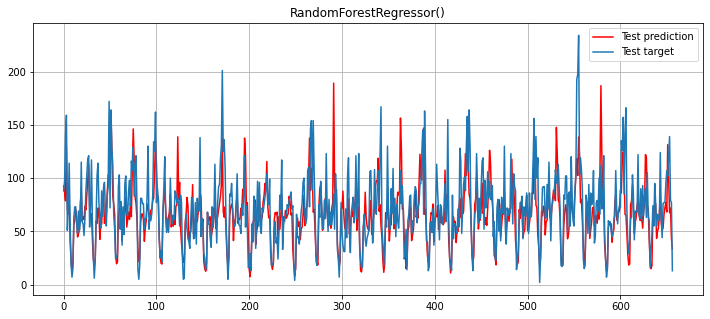

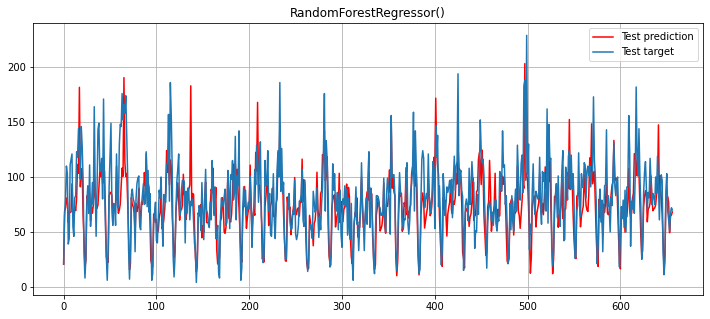

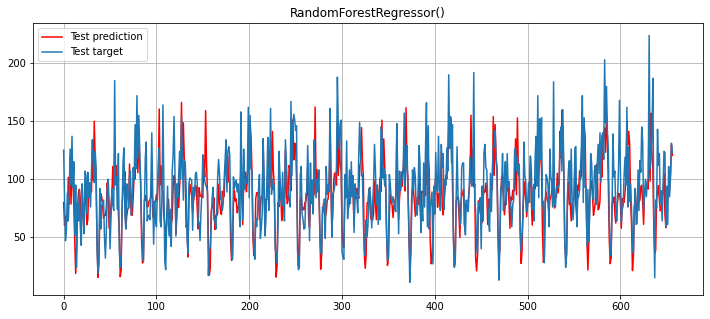

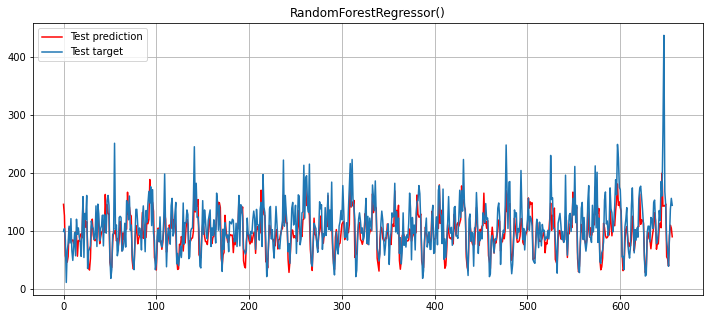

In [32]:
forest_cv = RandomForestRegressor()
forest_cv_rmse_train, forest_cv_rmse_test = TimeSeriesCV(features_train, target_train, 6, forest_cv)
metrics(forest_cv_rmse_train, forest_cv_rmse_test, 'CV Random Forest Regressor', results)

Для случайного леса кросс-валидация тоже показала неплохие результаты.

Попробуем дополнительно оценить, как с задачей справится LightGBM и CatBoost.

CPU times: user 1min 7s, sys: 401 ms, total: 1min 7s
Wall time: 1min 8s


,RMSE обучающей выборки,RMSE тестовой выборки
Linear Regression,30.907085,51.194081
Random Forest Regressor,8.686004,46.708868
CV Linear Regression,26.992019,31.797042
CV Random Forest Regressor,7.527633,25.657452
CV LightGBM,13.340499,28.682495
CV CatBoostRegressor,12.101015,29.010079


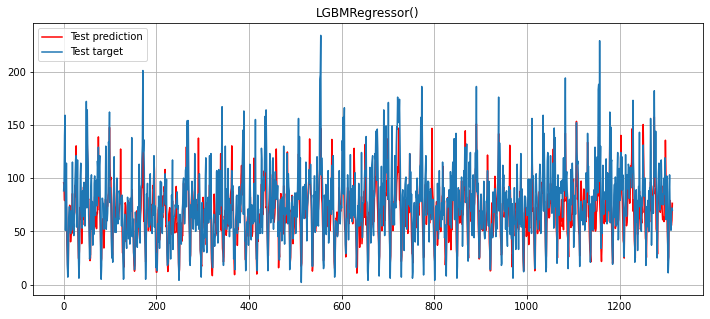

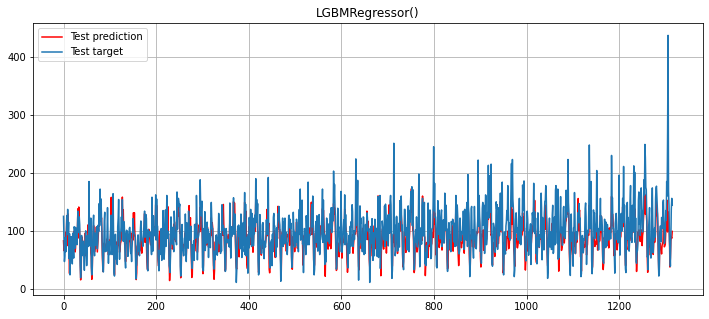

In [33]:
%%time
lgbm = LGBMRegressor()
lgbm_rmse_train, lgbm_rmse_test = TimeSeriesCV(features_train, target_train, 3, lgbm)
metrics(lgbm_rmse_train, lgbm_rmse_test, 'CV LightGBM', results)

LGBMR модель показала не лучшие, но неплохие результаты.

CPU times: user 1.65 s, sys: 152 ms, total: 1.81 s
Wall time: 4.27 s


,RMSE обучающей выборки,RMSE тестовой выборки
Linear Regression,30.907085,51.194081
Random Forest Regressor,8.686004,46.708868
CV Linear Regression,26.992019,31.797042
CV Random Forest Regressor,7.527633,25.657452
CV LightGBM,13.340499,28.682495
CV CatBoostRegressor,12.101015,29.010079


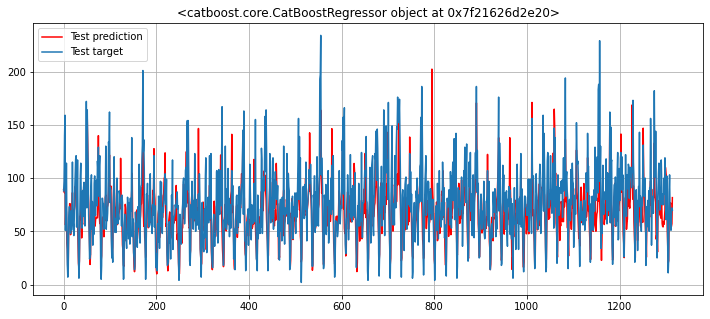

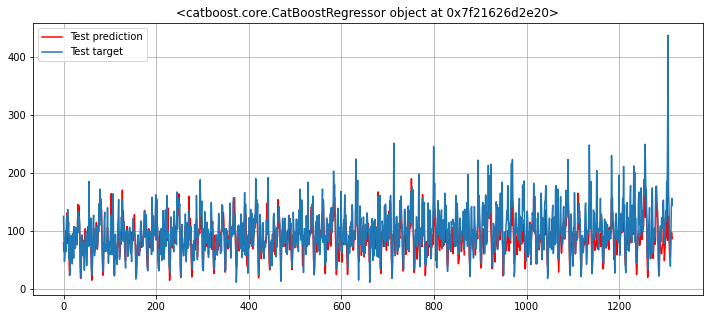

In [34]:
%%time
cat = CatBoostRegressor(verbose=False)
cat_rmse_train, cat_rmse_test = TimeSeriesCV(features_train, target_train, 3, cat)
metrics(cat_rmse_train, cat_rmse_test, 'CV CatBoostRegressor', results)

Модель CatBoost показала чуть меньшее значение метрики RMSE, чем предыдущая модель.

### Вывод

Для решения нашей задачи выберем ту модель, для которой метрика RMSE не более 48, минимальна, а также модель не должна иметь склонность к переобучению. 

По этим критериям выбираем модель *CV Linear Regression*.	

## Общий вывод


По итогам выполненной работы было сделано следующее:

* Произведена предварительная подготовка данных: был изменен тип данных столца datetime на тип datetime64 и установлены данные значения в качестве индексов, произведена проверка данных на монотонность и применено ресемплирование с детализацией даты до часов.


* Осуществлен анализ данных:
   - Получили, что среднее значение количества заказов такси со временем увеличивается, то есть представленный временной ряд является нестационарным, при этом наблюдается тренд на увеличение количества заказов такси от месяца к месяцу, а период сезонности соответствует примерно неделе.

   - В разрезе одной недели наибольшее количество заказов соответствует таким дням недели как понедельник и пятница, а минимальное - вторнику и воскресенью.

   - В разрезе одних суток пик заказов приходится на полночь, наименьшее количество заказов соотвествует 6 часам утра. Если выделять промежутки времени, когда заказов было больше всего, получаем время от полуночи до 4 часов утра, от 9:00 до 10:00, от 15:00 до 17:00 и от 20:00 и до полуночи.
   
   
* Для решения нашей задачи по построению модели машинного обучения для прогнозирования количества заказов такси на следующий час (со значением метрики RMSE на тестовой выборке не более 48) была выбрана модель лиинейной регрессии на кросс-валидации *CV Linear Regression*, для которой значения метрик RMSE составили для обучающей выборки 26.6, для тестовой - 31.4. 